In [1]:
import joblib
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Recharger le modèle XGBoost
xgb_model = joblib.load('xgb_model.pkl')

# Recharger les données prétraitées
X_train_preprocessed, X_test_preprocessed, y_train, y_test = joblib.load('preprocessed_data.pkl')
preprocessor = joblib.load('preprocessor.pkl')

In [3]:
probabilities = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
probabilities = np.round(probabilities, 4)
print(probabilities)

[0.0057 0.0006 0.0002 ... 0.037  0.0002 0.0017]


In [4]:
y_df = pd.DataFrame({'probability': probabilities, 'y_reel': y_test})

In [5]:
df_sorted = y_df.sort_values(by='probability')

In [6]:
def decile_analysis(y_prob, y_reel):
    dictionary = {}
    y_df = pd.DataFrame({'probability': y_prob, 'y_reel': y_reel})
    df_sorted = y_df.sort_values(by='probability')
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        df_divided = np.array_split(df_sorted, 10)
        
    for i, part in enumerate(df_divided):
        count_1 = part['y_reel'].value_counts().get(1, 0)
        dictionary[f'{i+1}'] = [
            f'{part.shape[0] // 1000}k', 
            min(part['probability']), 
            max(part['probability']),
            count_1
        ]
        
    count = pd.DataFrame(dictionary, index=['Nbr', 'Probability min', 'Probability max', 'Count 1'])
    vertical_percentage = count.iloc[-1:].div(count.iloc[-1:].sum(axis=1), axis=0) * 100
    vertical_percentage.index = ['Vertical % 1']
    
    # Arrondir les pourcentages verticaux à deux décimales
    vertical_percentage = vertical_percentage.applymap(lambda x: round(x, 2))

    horizontal_percentage = (count.iloc[-1] / (count.iloc[0].str.replace('k', '').astype(int) * 1000)) * 100
    horizontal_percentage.name = 'Horizontal % 1'
    
    return pd.concat([count, vertical_percentage, horizontal_percentage.to_frame().T], axis=0)

# Appeler la fonction decile_analysis avec les probabilités et les valeurs réelles
decile_stats = decile_analysis(probabilities, y_test)

# Afficher les statistiques des déciles
decile_stats


,1,2,3,4,5,6,7,8,9,10
Nbr,1k,1k,1k,1k,1k,1k,1k,1k,1k,1k
Probability min,0.0,0.0001,0.0002,0.0003,0.0005,0.0009,0.0014,0.0025,0.005,0.0114
Probability max,0.0001,0.0002,0.0003,0.0005,0.0009,0.0014,0.0025,0.005,0.0114,0.9994
Count 1,1,1,3,1,5,8,9,8,13,83
Vertical % 1,0.76,0.76,2.27,0.76,3.79,6.06,6.82,6.06,9.85,62.88
Horizontal % 1,0.1,0.1,0.3,0.1,0.5,0.8,0.9,0.8,1.3,8.3


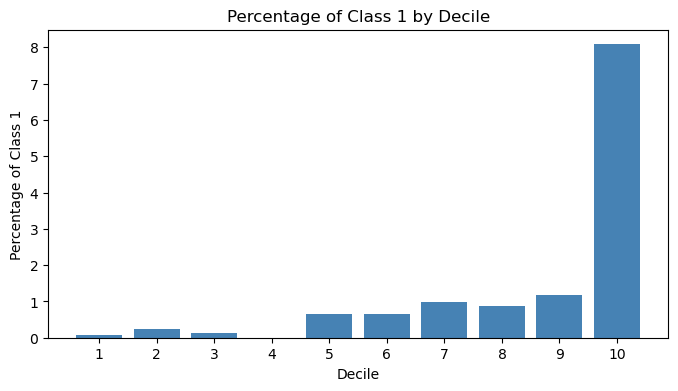

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'probabilities' are your model's predicted probabilities
# and 'y_test' are the actual labels (0s and 1s) of the test set

# Create a DataFrame with the predictions and actual labels
df = pd.DataFrame({'predictions': probabilities, 'actual': y_test})

# Sort the DataFrame by predictions in descending order
df_sorted = df.sort_values(by='predictions', ascending=False)

# Add a decile column (10 bins)
df_sorted['decile'] = pd.qcut(df_sorted['predictions'], 10, labels=False) + 1

# Calculate the percentage of class 1 in each decile
decile_analysis = df_sorted.groupby('decile')['actual'].mean() * 100

# Plot the decile analysis chart
plt.figure(figsize=(8, 4))
plt.bar(decile_analysis.index, decile_analysis.values, color='steelblue')
plt.xlabel('Decile')
plt.ylabel('Percentage of Class 1')
plt.title('Percentage of Class 1 by Decile')
plt.xticks(np.arange(1, 11, 1))  # Ensure x-axis has deciles 1 to 10
plt.show()
